<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
 <h2>Mentoría: Detección de objetos en imágenes </h2>
</center>



In [ ]:
from IPython.display import Image as Imge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Esta es una notebook autocontenida para el análisis de datos de la tabla de características de una de las carpetas de las imágenes del [Github](https://github.com/diegobcuadro/dataset_ManosyGuantes) propuesto para la mentoría *'Detección de objetos en imágenes'*.

pueden acceder desde el siguiente [link](https://drive.google.com/file/d/1XrG93Pxt-TTD_avUGy6nFXbHqyBh9tga/view?usp=sharing) a la tabla de features a analizar en esta notebook. Si utilizan la [carpeta compartida del Drive](https://drive.google.com/drive/folders/1Yr1ymy7t3u9YbDyOtFq_LR7WpIfvCyLU?usp=sharing), no es necesario descargarla.

Procedemos a cargar las librerias que vamos a estar utilizando para el analisis de dataset

In [ ]:
!pip install pandas_bokeh

In [ ]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
import pandas_bokeh
pandas_bokeh.output_notebook()

In [ ]:
# acá podemos indicar la capeta donde queremos estar. 
# Deberán cambiar la dirección, seguramente a uds se les agregará la carpeta en compartidas, por lo que deberán cambiar 
# el path de la siguiente línea:
import os
os.chdir('/content/drive/My Drive/DiploDatos2020/Mentoria')

from time import sleep
from tqdm.notebook import tqdm

import scipy
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# acá vamos importando las librerías necesarias 
# y a medida que van surgiendo por necesidad, las van sumando, para mantener un orden y poder ubicarlas rápido

import pandas as pd
pd.set_option('plotting.backend', 'pandas_bokeh')
import numpy as np
import glob

#seguimos agregando librerías necesarias:
#las que no tengan, vayan instalándolas
import cv2
import numpy as np

import matplotlib.pyplot as plt
import PIL
from PIL import Image
from os import path

from google.colab.patches import cv2_imshow #en Colab!

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def getKS(df,
          features,
          dist_names=['weibull_min', 'norm', 'weibull_max', 'beta', 'invgauss', 'gamma', 'expon', 'lognorm', 'triang']):
  # Set list of distributions to test
  # See https://docs.scipy.org/doc/scipy/reference/stats.html for more

  # Set up list of candidate distributions to use
  # See https://docs.scipy.org/doc/scipy/reference/stats.html for more

  # Distribuciones que se van a testear.
  # dist_names = ['weibull_min',
  #               'norm',
  #               'weibull_max',
  #               'beta',
  #               'invgauss',
  #               'gamma',
  #               'expon',
  #               'lognorm',
  #               'triang']

  if type(dist_names)==str: dist_names = list(dist_names.split())
  if type(features)==str: features = list(features.split())
  print("lista de features:", features)
  
  dist_val = pd.DataFrame(columns=['Feature', 'Distribution', 'D_value', 'p_value'])
  for feature in tqdm(features):
    import warnings
    warnings.filterwarnings("ignore")
    feature = str(feature)

    # Set up empty lists to stroe results
    d_values = []
    p_values = []

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(df[feature])

        # Obtain the KS test P statistic, round it to 5 decimal places
        val = scipy.stats.kstest(df[feature], distribution, args=param)
        d = np.around(val[0], 5)
        d_values.append(d)
        p = np.around(val[1], 5)
        p_values.append(p)    

    # Collate results and sort by goodness of fit (best at top)

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['D_value'] = d_values
    results['p_value'] = p_values
    results['Feature'] = feature
    results.sort_values(['p_value'], ascending=False, inplace=True)

    # Report results

    print ('\nDistributions sorted by goodness of fit:')
    print ('----------------------------------------')
    print (results)

    dist_val = dist_val.append(results.iloc[0], ignore_index=True)

  return dist_val

In [ ]:
os.chdir('/content/drive/My Drive/DiploDatos2020/Mentoria/Dataset-M/G/train/dataset')

In [ ]:
# Abrimos el archivo y lo chusmeamos:
dataset_train_MG_ = pd.read_csv('csv_wlabels_train_MG_df.csv', low_memory=False) #porqué low? no hay por qué. Sino no reconoce algunos tipos de columnas sino
dataset_train_MG = dataset_train_MG_.drop(['Unnamed: 0'], axis=1)
dataset_train_MG.head(5)

,filename,xmin,xmax,ymin,ymax,day_time,size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,M_G_Mostrando_Mano-Amarillo_0_double_box2.jpg,436,662,273,474,M,G,si,amarillo,1.192934,0.132554,0.292861,0.704324,0.043486,0.561370,0.492875,0.415565,0.606461,0.405709,0.532783,0.382000,0.859358,0.157759,0.539070,0.180152,0.087641,0.451658,0.067623,0.188491,0.273504,0.352612,0.365537,0.085581,0.049281,0.534786,0.346597,0.729510,0.327267,0.175310,0.214354,...,0.109618,0.201162,0.053464,0.400421,1.828703,0.766772,0.345443,0.320869,0.876834,1.105888,0.360420,0.137844,0.201754,0.184912,1.058968,0.694844,0.348436,0.221967,1.842808,0.593052,0.208990,0.419584,0.467739,0.847367,0.767512,0.429070,0.462808,0.097680,0.373019,0.055480,0.850606,0.618605,0.579222,0.214956,1.543457,0.240321,0.015946,0.498210,0.105096,0.415124
1,M_G_Mostrando_Mano-Amarillo_10_double_box2.jpg,307,503,227,357,M,G,si,amarillo,0.473153,0.326438,0.872934,0.272843,0.581942,0.085599,0.116944,1.393549,0.868530,0.557496,0.077261,0.120294,0.248606,0.222858,0.037286,0.110815,0.024490,0.304910,0.080512,0.987467,0.256264,0.208748,0.706314,0.027361,0.048373,0.121103,0.151871,0.414459,0.020769,0.036364,0.139919,...,0.114571,0.486142,0.007770,0.081066,0.650191,1.732524,0.107846,0.190294,0.139264,0.262592,0.818040,0.411074,0.561725,0.178695,1.652464,0.323930,0.114231,0.034584,0.112140,0.549182,0.521623,0.479088,0.086294,0.663143,0.556707,0.101734,0.252282,0.200444,0.193105,0.226180,0.327536,0.041440,0.610802,0.714450,1.010661,0.164083,0.489083,0.401081,0.334849,0.009120
2,M_G_Mostrando_Mano-Amarillo_11_double_box2.jpg,304,503,162,351,M,G,si,amarillo,0.551692,0.311296,0.630988,0.612515,0.324043,0.122678,0.292788,1.080067,0.315567,0.291490,0.299222,0.343937,0.387980,0.095756,0.041759,0.252472,0.021887,0.390645,0.009959,0.159158,0.046286,0.517520,0.329951,0.015500,0.208366,0.207085,0.477750,1.682721,0.211059,0.136033,0.004871,...,0.202850,0.283488,0.004961,0.331641,1.339007,1.408519,0.366572,0.162958,0.096853,0.572625,0.727882,0.139311,0.394578,0.234353,1.004670,0.320588,0.795888,0.018158,0.721928,0.496969,0.381788,0.381119,0.520868,0.709025,0.796566,0.022527,0.436449,0.095957,0.142214,0.054401,0.399043,0.194232,0.255874,0.506477,1.049478,0.093706,0.237381,0.270804,0.206780,0.021252
3,M_G_Mostrando_Mano-Amarillo_12_double_box2.jpg,320,516,102,308,M,G,si,amarillo,0.445529,1.104021,0.329798,0.772140,0.191984,0.092597,0.323702,0.493198,0.260759,0.254920,0.351949,0.659263,0.447098,0.195273,0.218607,0.268113,0.177694,0.234917,0.034185,1.457397,0.243114,0.227982,0.109678,0.034942,0.022739,0.370361,0.388175,1.431276,0.508981,0.182964,0.028220,...,0.342891,0.395380,0.000000,1.146170,2.406389,1.542115,0.599406,0.682540,0.349439,0.375349,0.910304,0.101252,0.310441,0.259261,0.752298,0.508452,1.337586,0.117757,0.462209,0.567773,0.316124,0.120465,0.518646,0.852264,0.879169,0.088652,0.956650,0.038115,0.170151,0.015820,0.151291,0.084338,0.546983,0.239140,0.521701,0.121823,0.056032,0.503652,0.516597,0.325798
4,M_G_Mostrando_Mano-Amarillo_13_double_box2.jpg,323,507,76,291,M,G,si,amarillo,0.401482,1.118310,0.485366,0.686955,0.046806,0.203579,0.343371,0.685662,0.365654,0.238447,0.164747,0.638464,0.357792,0.310761,0.130233,0.190511,0.145574,0.047850,0.008097,0.955863,0.202188,0.456735,0.175217,0.003151,0.091389,0.384982,0.245546,1.183161,0.610042,0.135109,0.068913,...,0.183034,0.248365,0.004623,1.021811,1.633345,1.578439,0.513223,0.543867,0.239947,0.230462,0.854492,0.106203,0.446704,0.263999,0.866798,0.268687,1.261234,0.019139,0.585002,0.505261,0.361614,0.125756,0.382490,1.262282,0.557245,0.088643,1.130196,0.005393,0.386618,0.028207,0.361752,0.200909,0.574926,0.532086,0.517593,0.025498,0.058469,0.502583,0.073139,0.072178


In [ ]:
#Entradas en el dataset
print(f'El dataset posee {dataset_train_MG.shape[0]} filas x {dataset_train_MG.shape[1]} columnas')

El dataset posee 1996 filas x 2057 columnas


In [ ]:
#Tipo de variables en el dataset
dataset_train_MG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1996 entries, 0 to 1995
Columns: 2057 entries, filename to 2047
dtypes: float64(2048), int64(4), object(5)
memory usage: 31.3+ MB


In [ ]:
#Valores en variables categoricas
dataset_train_MG.day_time.unique(), dataset_train_MG['size'].unique(), dataset_train_MG.guantes.unique(), dataset_train_MG.color.unique()

(array(['M'], dtype=object),
 array(['G'], dtype=object),
 array(['si', 'no'], dtype=object),
 array(['amarillo', 'verde', 'mano'], dtype=object))

In [ ]:
#Cantidad de fotos con y sin guantes
dataset_train_MG.groupby(['guantes', 'color']).size()

guantes  color   
no       mano        721
si       amarillo    587
         verde       688
dtype: int64

Obtenemos el AREA de cada imagen

In [ ]:
dataset_train_MG
dataset_train_MG['Area'] = dataset_train_MG[['xmin','xmax','ymin','ymax']].apply(lambda x: (x['xmax']-x['xmin'])*(x['ymax']-x['ymin']), axis=1)
cols = list(dataset_train_MG)
cols.insert(5, cols.pop(cols.index('Area')))
dataset_train_MG = dataset_train_MG.loc[:, cols]
dataset_train_MG

,filename,xmin,xmax,ymin,ymax,Area,day_time,size,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,M_G_Mostrando_Mano-Amarillo_0_double_box2.jpg,436,662,273,474,45426,M,G,si,amarillo,1.192934,0.132554,0.292861,0.704324,0.043486,0.561370,0.492875,0.415565,0.606461,0.405709,0.532783,0.382000,0.859358,0.157759,0.539070,0.180152,0.087641,0.451658,0.067623,0.188491,0.273504,0.352612,0.365537,0.085581,0.049281,0.534786,0.346597,0.729510,0.327267,0.175310,...,0.109618,0.201162,0.053464,0.400421,1.828703,0.766772,0.345443,0.320869,0.876834,1.105888,0.360420,0.137844,0.201754,0.184912,1.058968,0.694844,0.348436,0.221967,1.842808,0.593052,0.208990,0.419584,0.467739,0.847367,0.767512,0.429070,0.462808,0.097680,0.373019,0.055480,0.850606,0.618605,0.579222,0.214956,1.543457,0.240321,0.015946,0.498210,0.105096,0.415124
1,M_G_Mostrando_Mano-Amarillo_10_double_box2.jpg,307,503,227,357,25480,M,G,si,amarillo,0.473153,0.326438,0.872934,0.272843,0.581942,0.085599,0.116944,1.393549,0.868530,0.557496,0.077261,0.120294,0.248606,0.222858,0.037286,0.110815,0.024490,0.304910,0.080512,0.987467,0.256264,0.208748,0.706314,0.027361,0.048373,0.121103,0.151871,0.414459,0.020769,0.036364,...,0.114571,0.486142,0.007770,0.081066,0.650191,1.732524,0.107846,0.190294,0.139264,0.262592,0.818040,0.411074,0.561725,0.178695,1.652464,0.323930,0.114231,0.034584,0.112140,0.549182,0.521623,0.479088,0.086294,0.663143,0.556707,0.101734,0.252282,0.200444,0.193105,0.226180,0.327536,0.041440,0.610802,0.714450,1.010661,0.164083,0.489083,0.401081,0.334849,0.009120
2,M_G_Mostrando_Mano-Amarillo_11_double_box2.jpg,304,503,162,351,37611,M,G,si,amarillo,0.551692,0.311296,0.630988,0.612515,0.324043,0.122678,0.292788,1.080067,0.315567,0.291490,0.299222,0.343937,0.387980,0.095756,0.041759,0.252472,0.021887,0.390645,0.009959,0.159158,0.046286,0.517520,0.329951,0.015500,0.208366,0.207085,0.477750,1.682721,0.211059,0.136033,...,0.202850,0.283488,0.004961,0.331641,1.339007,1.408519,0.366572,0.162958,0.096853,0.572625,0.727882,0.139311,0.394578,0.234353,1.004670,0.320588,0.795888,0.018158,0.721928,0.496969,0.381788,0.381119,0.520868,0.709025,0.796566,0.022527,0.436449,0.095957,0.142214,0.054401,0.399043,0.194232,0.255874,0.506477,1.049478,0.093706,0.237381,0.270804,0.206780,0.021252
3,M_G_Mostrando_Mano-Amarillo_12_double_box2.jpg,320,516,102,308,40376,M,G,si,amarillo,0.445529,1.104021,0.329798,0.772140,0.191984,0.092597,0.323702,0.493198,0.260759,0.254920,0.351949,0.659263,0.447098,0.195273,0.218607,0.268113,0.177694,0.234917,0.034185,1.457397,0.243114,0.227982,0.109678,0.034942,0.022739,0.370361,0.388175,1.431276,0.508981,0.182964,...,0.342891,0.395380,0.000000,1.146170,2.406389,1.542115,0.599406,0.682540,0.349439,0.375349,0.910304,0.101252,0.310441,0.259261,0.752298,0.508452,1.337586,0.117757,0.462209,0.567773,0.316124,0.120465,0.518646,0.852264,0.879169,0.088652,0.956650,0.038115,0.170151,0.015820,0.151291,0.084338,0.546983,0.239140,0.521701,0.121823,0.056032,0.503652,0.516597,0.325798
4,M_G_Mostrando_Mano-Amarillo_13_double_box2.jpg,323,507,76,291,39560,M,G,si,amarillo,0.401482,1.118310,0.485366,0.686955,0.046806,0.203579,0.343371,0.685662,0.365654,0.238447,0.164747,0.638464,0.357792,0.310761,0.130233,0.190511,0.145574,0.047850,0.008097,0.955863,0.202188,0.456735,0.175217,0.003151,0.091389,0.384982,0.245546,1.183161,0.610042,0.135109,...,0.183034,0.248365,0.004623,1.021811,1.633345,1.578439,0.513223,0.543867,0.239947,0.230462,0.854492,0.106203,0.446704,0.263999,0.866798,0.268687,1.261234,0.019139,0.585002,0.505261,0.361614,0.125756,0.382490,1.262282,0.557245,0.088643,1.130196,0.005393,0.386618,0.028207,0.361752,0.200909,0.574926,0.532086,0.517593,0.025498,0.058469,0.502583,0.073139,0.072178
...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# Calculamos la media, desviacion estandard y mediana de las superficies de las imagenes
dataset_train_MG['Area'].describe()

count      1996.000000
mean      36837.969940
std       17931.822768
min        6090.000000
25%       23854.500000
50%       33815.500000
75%       44726.000000
max      128340.000000
Name: Area, dtype: float64

Vamos a realizar un histograma para ver cual es el grafico de distribucion de los valores obtenidos para el Area de las imagenes.

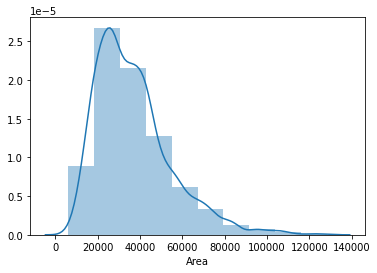

In [ ]:
sns.distplot(dataset_train_MG['Area'], bins=10)

Por el grafico de distribucion obtenido, podemos inferir que los valores del area de cada imagen, corresponden a una distribucion Beta.
Vamos a realizar una prueba de Kolmogorov Smirnov para verificar esto.

In [ ]:
getKS(dataset_train_MG, 'Area', 'beta')

lista de features: ['Area']



Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
0         beta   0.0268   0.1117    Area



,Feature,Distribution,D_value,p_value
0,Area,beta,0.0268,0.1117


Dados los valores obtenidos en la prueba de KS, no podemos descartar que la distribucion correspondiente a los valores del Area corresponda a una distribucion Beta

A continuacion, vamos a buscar valores donde la desviacion estandar represente un porcentaje bajo respecto de la media, para ver aquellos features donde haya poca dispersion de valores

In [ ]:
df_spread = []
for col in dataset_train_MG.columns[10:]:
  val = dataset_train_MG[col].std() / dataset_train_MG[col].mean() * 100
  df_spread.append(val)
print(*[(idx, x)for idx, x in enumerate(df_spread) if x < 30], sep='\n')

(990, 28.74011726291662)
(1680, 29.387231838260774)
(1772, 29.559647961078124)


In [ ]:
df_cols = [str(idx) for idx, x in enumerate(df_spread) if x < 30]
print(f"Features con valores cercanos a la media: {df_cols}")

Features con valores cercanos a la media: ['990', '1680', '1772']


Podemos observar que los Features '990', '1680', '1772' poseen valores cercanos a la media independientemente de la foto que se analice, si posee guante o no, si el guante es de distinto color.

In [ ]:
dataset_train_MG[df_cols].describe()

,990,1680,1772
count,1996.000000,1996.000000,1996.000000
mean,2.633403,0.320620,2.188882
std,0.756843,0.094221,0.647026
min,0.496420,0.059702,0.355525
25%,2.087280,0.255017,1.749600
50%,2.637587,0.313881,2.183558
75%,3.157135,0.376295,2.613752
max,4.947293,0.730603,4.423331


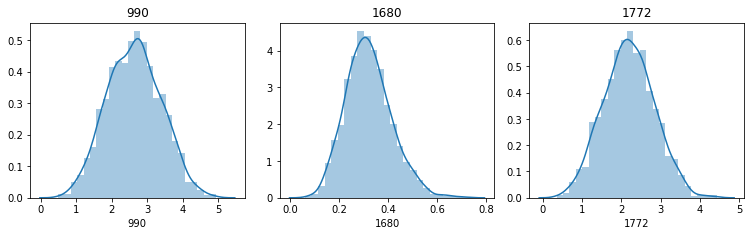

In [ ]:
fig = plt.figure(figsize=(14,12))
for n, feature in enumerate(df_cols):
    ax = fig.add_subplot(4,4,n+1)
    ax = sns.distplot(dataset_train_MG[feature], bins=25)
    ax.set_title(feature)
plt.tight_layout()
plt.show()

A priori se puede observar que todas las features seleccionadas pueden pertenecer a una distribucion Normal o Beta (Distribucion Beta puede tomar una forma simetrica similar a Normal si sus parametros alfa y beta son iguales). Vamos a chequear con un test de KS para verificar si se puede descartar o no esta apreciacion.

In [ ]:
getKS(dataset_train_MG, df_cols, ['norm', 'beta'])

lista de features: ['990', '1680', '1772']



Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
1         beta  0.01319  0.87802     990
0         norm  0.02463  0.17475     990

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
1         beta  0.01285  0.89656    1680
0         norm  0.03792  0.00626    1680

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
1         beta  0.01204   0.9343    1772
0         norm  0.01346   0.8627    1772



,Feature,Distribution,D_value,p_value
0,990,beta,0.01319,0.87802
1,1680,beta,0.01285,0.89656
2,1772,beta,0.01204,0.93430


Por el resultado del test de KS, no podemos rechazar la hipotesis de que la distribucion sea Beta.

In [ ]:
cols = dataset_train_MG.columns[10:]
print(cols)

# Tomamos la mediana de todo el dataset

ds_median = dataset_train_MG[cols].median()

list1 = list(ds_median)
df1 = pd.DataFrame(list1, columns=['todos'])
df1.index.name = 'feature'
df1.head()

# En este caso tomamos la mediana ya que al tener valores muy dispersos en los features, 
# y con distribuciones no normales, la media podria no ser representativa

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046',
       '2047'],
      dtype='object', length=2048)


,todos
feature,
0,0.388510
1,0.267596
2,0.367479
3,0.304431
4,0.168932


Vamos a realizar un analisis partiendo de un articulo de Medium donde se explica el significado y funcionamiento del Feature Vector que obtuvimos para cada imagen.

El post de Medium se puede encontrar aqui: https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030

En este post se explica que cada valor del Feature Vector corresponde a la activacion media de un filtro determinado al pasar la imagen por la CNN.
Cada "pico" en el siguiente grafico, representa la media del valor de activacion para cada feature de las imagenes; esto quiere decir que cada feature del vector representa un filtro y su nivel de activacion de la imagen al pasar por la red neuronal.

In [ ]:
df1.plot_bokeh.line(
    figsize=(800, 450),
    title="Features",
    xticks=[int(x) for x in df_cols],
    ylim=(0, 4),
    toolbar_location=None,
    colormap=["red"],
)

Figure(id='1251', ...)

## Buscamos la correlacion entre Fotos con guantes o sin guantes y los Features del vector

Primero tomamos como muestra de nuestra poblacion todas las imagenes del dataset y vamos a realizar un estudio de correlacion para determinar que features inciden en que en la imagen haya una mano con o sin guante

In [ ]:
# Realizamos un Label Encoder para pasar pasar nuestras variables categoricas de guantes si o no a valores numericos.

df_enc = dataset_train_MG.copy()
df_enc['guantes_enc'] = LabelEncoder().fit_transform(dataset_train_MG['guantes'])
cols = df_enc.columns[:10]
df_enc = df_enc.drop(cols, axis=1)
df_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,guantes_enc
0,1.192934,0.132554,0.292861,0.704324,0.043486,0.561370,0.492875,0.415565,0.606461,0.405709,0.532783,0.382000,0.859358,0.157759,0.539070,0.180152,0.087641,0.451658,0.067623,0.188491,0.273504,0.352612,0.365537,0.085581,0.049281,0.534786,0.346597,0.729510,0.327267,0.175310,0.214354,0.317487,0.426788,0.240604,0.475524,0.102401,0.288812,0.480376,0.115266,0.219201,...,0.201162,0.053464,0.400421,1.828703,0.766772,0.345443,0.320869,0.876834,1.105888,0.360420,0.137844,0.201754,0.184912,1.058968,0.694844,0.348436,0.221967,1.842808,0.593052,0.208990,0.419584,0.467739,0.847367,0.767512,0.429070,0.462808,0.097680,0.373019,0.055480,0.850606,0.618605,0.579222,0.214956,1.543457,0.240321,0.015946,0.498210,0.105096,0.415124,1
1,0.473153,0.326438,0.872934,0.272843,0.581942,0.085599,0.116944,1.393549,0.868530,0.557496,0.077261,0.120294,0.248606,0.222858,0.037286,0.110815,0.024490,0.304910,0.080512,0.987467,0.256264,0.208748,0.706314,0.027361,0.048373,0.121103,0.151871,0.414459,0.020769,0.036364,0.139919,0.699371,0.425649,0.186967,0.528327,0.061758,0.038064,0.177612,0.424630,0.047973,...,0.486142,0.007770,0.081066,0.650191,1.732524,0.107846,0.190294,0.139264,0.262592,0.818040,0.411074,0.561725,0.178695,1.652464,0.323930,0.114231,0.034584,0.112140,0.549182,0.521623,0.479088,0.086294,0.663143,0.556707,0.101734,0.252282,0.200444,0.193105,0.226180,0.327536,0.041440,0.610802,0.714450,1.010661,0.164083,0.489083,0.401081,0.334849,0.009120,1
2,0.551692,0.311296,0.630988,0.612515,0.324043,0.122678,0.292788,1.080067,0.315567,0.291490,0.299222,0.343937,0.387980,0.095756,0.041759,0.252472,0.021887,0.390645,0.009959,0.159158,0.046286,0.517520,0.329951,0.015500,0.208366,0.207085,0.477750,1.682721,0.211059,0.136033,0.004871,0.536020,0.570962,0.206789,0.265336,0.035087,0.044212,0.424286,0.186841,0.127613,...,0.283488,0.004961,0.331641,1.339007,1.408519,0.366572,0.162958,0.096853,0.572625,0.727882,0.139311,0.394578,0.234353,1.004670,0.320588,0.795888,0.018158,0.721928,0.496969,0.381788,0.381119,0.520868,0.709025,0.796566,0.022527,0.436449,0.095957,0.142214,0.054401,0.399043,0.194232,0.255874,0.506477,1.049478,0.093706,0.237381,0.270804,0.206780,0.021252,1
3,0.445529,1.104021,0.329798,0.772140,0.191984,0.092597,0.323702,0.493198,0.260759,0.254920,0.351949,0.659263,0.447098,0.195273,0.218607,0.268113,0.177694,0.234917,0.034185,1.457397,0.243114,0.227982,0.109678,0.034942,0.022739,0.370361,0.388175,1.431276,0.508981,0.182964,0.028220,0.393446,0.345359,0.130158,0.319913,0.135042,0.022699,0.220346,0.171796,0.315353,...,0.395380,0.000000,1.146170,2.406389,1.542115,0.599406,0.682540,0.349439,0.375349,0.910304,0.101252,0.310441,0.259261,0.752298,0.508452,1.337586,0.117757,0.462209,0.567773,0.316124,0.120465,0.518646,0.852264,0.879169,0.088652,0.956650,0.038115,0.170151,0.015820,0.151291,0.084338,0.546983,0.239140,0.521701,0.121823,0.056032,0.503652,0.516597,0.325798,1
4,0.401482,1.118310,0.485366,0.686955,0.046806,0.203579,0.343371,0.685662,0.365654,0.238447,0.164747,0.638464,0.357792,0.310761,0.130233,0.190511,0.145574,0.047850,0.008097,0.955863,0.202188,0.456735,0.175217,0.003151,0.091389,0.384982,0.245546,1.183161,0.610042,0.135109,0.068913,0.321653,0.302858,0.091547,0.279908,0.051548,0.041776,0.094347,0.280549,0.451248,...,0.248365,0.004623,1.021811,1.633345,1.578439,0.513223,0.543867,0.239947,0.230462,0.854492,0.106203,0.446704,0.263999,0.866798,0.268687,1.261234,0.019139,0.585002,0.505261,0.361614,0.125756,0.382490,1.262282,0.557245,0.088643,1.130196,0.005393,0.386618,0.028207,0.361752,0.200909,0.574926,0.532086,0.517593,0.025498,0.058469,0.502583,0.073139,0.072178,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
# Aqui determinamos la correlacion entre los features
corr_ = df_enc.corr()

In [ ]:
# Procedemos a quedarnos con los features que esten mas relacionados en valor absoluto con el feature de guantes si o no.
gsi_corr = corr_['guantes_enc']
gsi_corr = gsi_corr.abs().sort_values(ascending=False)
gsi_corr[1:6]

481     0.624925
1933    0.606805
707     0.573758
164     0.560936
1528    0.550082
Name: guantes_enc, dtype: float64

In [ ]:
corr_features = gsi_corr[1:6].index.values
print(f"Las features mas relacionadas con GUANTE SI O NO son: {gsi_corr[1:6].index.values}")

Las features mas relacionadas con GUANTE SI O NO son: ['481' '1933' '707' '164' '1528']


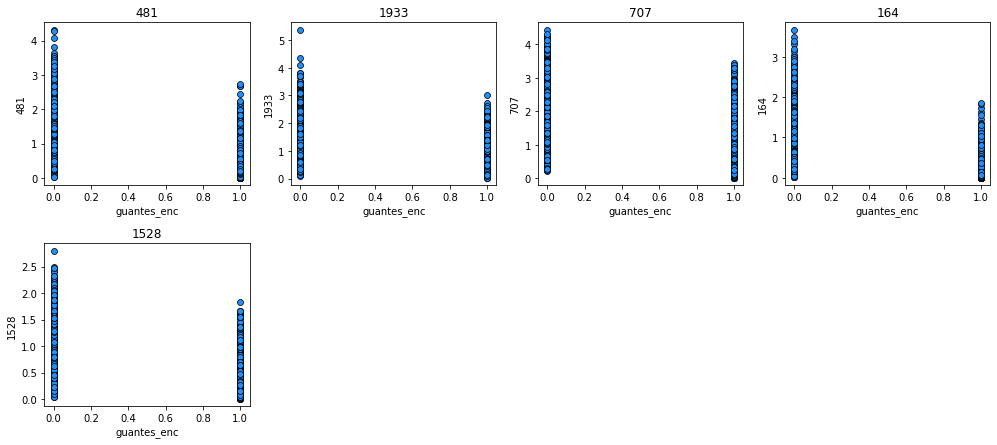

In [ ]:
fig = plt.figure(figsize=(14,12))
for n, feature in enumerate(corr_features):
    ax = fig.add_subplot(4,4,n+1)
    ax = sns.scatterplot(df_enc['guantes_enc'], df_enc[feature], facecolor="dodgerblue", edgecolor="k")
    ax.set_title(feature)

plt.tight_layout()
plt.show()

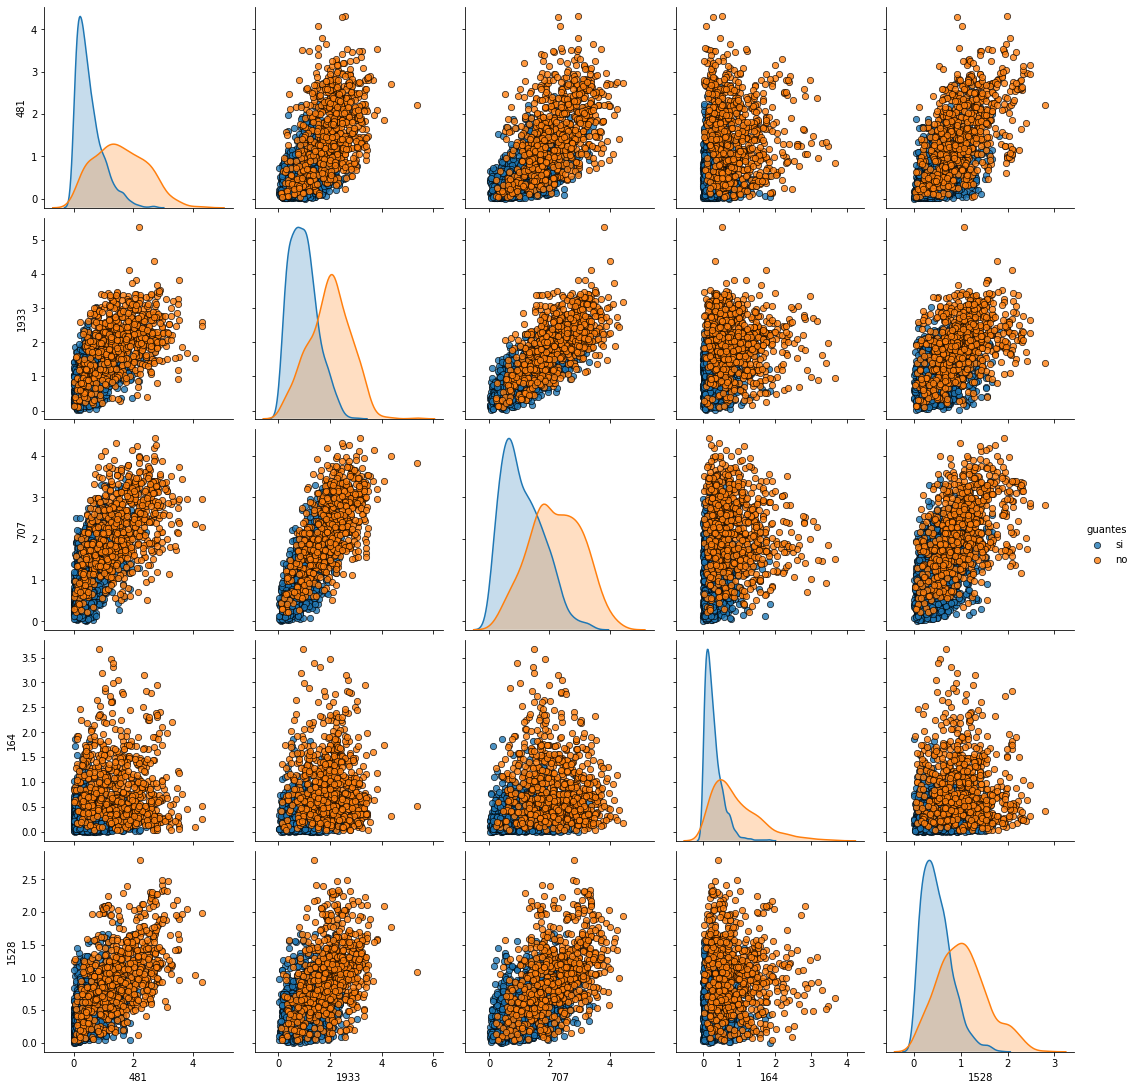

In [ ]:
#realizamos un pairplot para ver gráficamente las tendencias de los features seleccionados

sns.pairplot(data=dataset_train_MG, vars=corr_features, hue='guantes', height=3, plot_kws=
    {
    "s":40,
    "alpha":0.8,
    'lw':0.5,
    'edgecolor':'k'
    })

Tambien podemos observar que hay correlacion entre algunas de las features seleccionadas.
Se observa con claridad como varia la distribucion de las features dependiendo de que tenga guante o no en la foto.

In [ ]:
getKS(df_enc[df_enc['guantes_enc']==0], corr_features)

lista de features: ['481' '1933' '707' '164' '1528']



Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
3         beta  0.02941  0.56357     481
0  weibull_min  0.03813  0.23947     481
2  weibull_max  0.03959  0.20325     481
1         norm  0.04045  0.18397     481
7      lognorm  0.04258  0.14228     481
5        gamma  0.04337  0.12900     481
4     invgauss  0.04499  0.10471     481
8       triang  0.06893  0.00201     481
6        expon  0.19164  0.00000     481

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
3         beta  0.03044  0.51500    1933
1         norm  0.03248  0.42745    1933
0  weibull_min  0.03368  0.38112    1933
5        gamma  0.03419  0.36245    1933
7      lognorm  0.03439  0.35535    1933
2  weibull_max  0.05253  0.03606    1933
4     invgauss  0.06121  0.00863    1933
6        expon  0.26918  0.00000    1933
8       triang  0.18109  0.00000    1933

Distributions

,Feature,Distribution,D_value,p_value
0,481,beta,0.02941,0.56357
1,1933,beta,0.03044,0.51500
2,707,beta,0.02441,0.78362
3,164,gamma,0.02305,0.83840
4,1528,gamma,0.02141,0.89579


In [ ]:
getKS(df_enc[df_enc['guantes_enc']==1], corr_features)

lista de features: ['481' '1933' '707' '164' '1528']



Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
5        gamma  0.01278  0.98528     481
0  weibull_min  0.01540  0.92306     481
3         beta  0.01963  0.70962     481
4     invgauss  0.03115  0.16490     481
7      lognorm  0.03239  0.13472     481
2  weibull_max  0.06279  0.00008     481
1         norm  0.11899  0.00000     481
6        expon  0.07241  0.00000     481
8       triang  0.28170  0.00000     481

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
3         beta  0.01704  0.85302    1933
0  weibull_min  0.02241  0.54369    1933
4     invgauss  0.03395  0.10340    1933
7      lognorm  0.03453  0.09348    1933
2  weibull_max  0.03499  0.08604    1933
5        gamma  0.03589  0.07313    1933
1         norm  0.05054  0.00286    1933
6        expon  0.18192  0.00000    1933
8       triang  0.13216  0.00000    1933

Distributions

,Feature,Distribution,D_value,p_value
0,481,gamma,0.01278,0.98528
1,1933,beta,0.01704,0.85302
2,707,beta,0.02337,0.48929
3,164,weibull_min,0.01927,0.73102
4,1528,weibull_min,0.01122,0.99714


Al hacer las pruebas de KS para las variables cuando guantes = si y para guantes = no, vemos distintos resultados en el fit de distribucion de todas menos de la 1933 y 707, que se mantienen con distribucion Beta.

In [ ]:
cols = dataset_train_MG.columns[10:]
print(cols)

# Tomamos la mediana de cada grupo para realizar un grafico comparativo entre los tres

guante_si = dataset_train_MG[dataset_train_MG['guantes']=='si'][cols].median()
guante_no = dataset_train_MG[dataset_train_MG['guantes']=='no'][cols].median()

# Nos vamos a quedar solo con las columnas de filename, color y los feature vectors de dataset original

list1 = list(zip(guante_si, guante_no))
df1 = pd.DataFrame(list1, columns=['guante_si', 'guante_no'])
df1.index.name = 'feature'
df1.head()

# En este caso tomamos la mediana ya que al tener valores muy dispersos en los features, 
# y con distribuciones no normales, la media podria no ser representativa

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046',
       '2047'],
      dtype='object', length=2048)


,guante_si,guante_no
feature,,
0,0.495536,0.264785
1,0.277144,0.246876
2,0.395551,0.322757
3,0.304784,0.303937
4,0.170227,0.164471


Realizamos el grafico lineal de la mediana de los valores que toman los distintos features del dataset, para guantes si y guantes no, y observamos la diferencia entre los picos de los features.

In [ ]:
df1.plot_bokeh.line(
    y=['guante_si', 'guante_no'],
    figsize=(800, 450),
    title="Features",
    vertical_xlabel=True,
    xticks=[int(x) for x in corr_features],
    ylim=(0, 4),
    toolbar_location=None,
    colormap=["red", "blue"],
)

Figure(id='1372', ...)

### Realizaremos el mismo analisis, pero tomando como muestra aquellas imagenes que poseen guantes, y trataremos de determinar que features son indicativas de los colores del guante.

In [ ]:
# Analizaremos los valores para aquellos que si tienen guantes

df_gsi = dataset_train_MG[dataset_train_MG['guantes']=='si']

In [ ]:
df_gsi.describe()

,xmin,xmax,ymin,ymax,Area,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,...,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,746.512941,957.752941,246.169412,425.284706,39075.807059,0.575307,0.350215,0.459284,0.382170,0.222424,0.262651,0.502070,0.998356,0.501754,0.297896,0.344775,0.303117,0.554400,0.324226,0.219282,0.158175,0.239370,0.412646,0.494413,0.232278,0.173111,0.385921,0.505194,0.385217,0.275294,0.317726,0.302423,0.700825,0.226834,0.188187,0.207710,0.379275,0.224241,0.318838,0.327340,...,0.395321,0.235466,0.076408,0.431912,1.157282,1.118790,0.156222,0.351646,0.423719,0.665448,0.367249,0.288341,0.210416,0.162399,0.800054,0.448369,0.592222,0.187745,0.818414,0.545115,0.171127,0.428444,0.239840,0.512621,0.723793,0.215206,0.342728,0.250477,0.369711,0.150747,0.486265,0.419054,0.411523,0.307496,0.741748,0.310231,0.254667,0.291949,0.202915,0.224540
std,312.296354,313.317689,108.543177,141.669563,18522.621269,0.398806,0.282192,0.337333,0.295093,0.200157,0.226883,0.324945,0.413336,0.320404,0.197697,0.265737,0.335844,0.385433,0.212106,0.185019,0.136805,0.229906,0.269083,0.410160,0.240279,0.161142,0.252061,0.412344,0.371846,0.290121,0.206777,0.241059,0.440928,0.181020,0.161315,0.180063,0.326776,0.154250,0.251356,0.215508,...,0.268265,0.159861,0.091899,0.314340,0.730352,0.530805,0.133422,0.291994,0.286944,0.360672,0.290550,0.210499,0.154916,0.117247,0.650003,0.275700,0.389735,0.162363,0.492989,0.285675,0.151047,0.270561,0.184055,0.320303,0.337492,0.213413,0.347612,0.215986,0.215185,0.156337,0.329406,0.419590,0.339091,0.253770,0.392936,0.223053,0.212222,0.196506,0.210597,0.167777
min,14.000000,326.000000,0.000000,150.000000,6090.000000,0.000390,0.001054,0.000000,0.000268,0.000000,0.000000,0.013534,0.065238,0.000000,0.001487,0.000000,0.000000,0.001836,0.001869,0.000000,0.000000,0.000000,0.011622,0.001576,0.000000,0.000000,0.001431,0.003762,0.000000,0.000000,0.000000,0.000000,0.000757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001140,...,0.001138,0.000000,0.000000,0.000000,0.025835,0.177866,0.000000,0.000000,0.003355,0.026074,0.000635,0.004331,0.000000,0.000000,0.004169,0.000000,0.006605,0.000000,0.030766,0.031749,0.000000,0.002469,0.000159,0.003396,0.042753,0.000000,0.000000,0.000000,0.008218,0.000000,0.003120,0.000000,0.000000,0.000000,0.037513,0.000200,0.000000,0.000000,0.000000,0.000000
25%,540.000000,737.500000,169.500000,317.500000,26185.000000,0.276222,0.141592,0.222214,0.158876,0.072425,0.098304,0.261538,0.688417,0.264149,0.155608,0.156091,0.096894,0.260972,0.167058,0.078726,0.054083,0.077955,0.210398,0.173671,0.073175,0.054806,0.203960,0.197471,0.113208,0.066628,0.159706,0.127209,0.378864,0.091482,0.069182,0.074316,0.156268,0.106648,0.140998,0.165193,...,0.195199,0.108605,0.012464,0.207786,0.563619,0.723544,0.057688,0.146942,0.212672,0.405968,0.149989,0.130390,

In [ ]:
dfgsi_enc = df_gsi.copy()
dfgsi_enc['color_enc'] = LabelEncoder().fit_transform(df_gsi['color'])
cols = dfgsi_enc.columns[:10]
dfgsi_enc = dfgsi_enc.drop(cols, axis=1)
dfgsi_enc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,color_enc
0,1.192934,0.132554,0.292861,0.704324,0.043486,0.561370,0.492875,0.415565,0.606461,0.405709,0.532783,0.382000,0.859358,0.157759,0.539070,0.180152,0.087641,0.451658,0.067623,0.188491,0.273504,0.352612,0.365537,0.085581,0.049281,0.534786,0.346597,0.729510,0.327267,0.175310,0.214354,0.317487,0.426788,0.240604,0.475524,0.102401,0.288812,0.480376,0.115266,0.219201,...,0.201162,0.053464,0.400421,1.828703,0.766772,0.345443,0.320869,0.876834,1.105888,0.360420,0.137844,0.201754,0.184912,1.058968,0.694844,0.348436,0.221967,1.842808,0.593052,0.208990,0.419584,0.467739,0.847367,0.767512,0.429070,0.462808,0.097680,0.373019,0.055480,0.850606,0.618605,0.579222,0.214956,1.543457,0.240321,0.015946,0.498210,0.105096,0.415124,0
1,0.473153,0.326438,0.872934,0.272843,0.581942,0.085599,0.116944,1.393549,0.868530,0.557496,0.077261,0.120294,0.248606,0.222858,0.037286,0.110815,0.024490,0.304910,0.080512,0.987467,0.256264,0.208748,0.706314,0.027361,0.048373,0.121103,0.151871,0.414459,0.020769,0.036364,0.139919,0.699371,0.425649,0.186967,0.528327,0.061758,0.038064,0.177612,0.424630,0.047973,...,0.486142,0.007770,0.081066,0.650191,1.732524,0.107846,0.190294,0.139264,0.262592,0.818040,0.411074,0.561725,0.178695,1.652464,0.323930,0.114231,0.034584,0.112140,0.549182,0.521623,0.479088,0.086294,0.663143,0.556707,0.101734,0.252282,0.200444,0.193105,0.226180,0.327536,0.041440,0.610802,0.714450,1.010661,0.164083,0.489083,0.401081,0.334849,0.009120,0
2,0.551692,0.311296,0.630988,0.612515,0.324043,0.122678,0.292788,1.080067,0.315567,0.291490,0.299222,0.343937,0.387980,0.095756,0.041759,0.252472,0.021887,0.390645,0.009959,0.159158,0.046286,0.517520,0.329951,0.015500,0.208366,0.207085,0.477750,1.682721,0.211059,0.136033,0.004871,0.536020,0.570962,0.206789,0.265336,0.035087,0.044212,0.424286,0.186841,0.127613,...,0.283488,0.004961,0.331641,1.339007,1.408519,0.366572,0.162958,0.096853,0.572625,0.727882,0.139311,0.394578,0.234353,1.004670,0.320588,0.795888,0.018158,0.721928,0.496969,0.381788,0.381119,0.520868,0.709025,0.796566,0.022527,0.436449,0.095957,0.142214,0.054401,0.399043,0.194232,0.255874,0.506477,1.049478,0.093706,0.237381,0.270804,0.206780,0.021252,0
3,0.445529,1.104021,0.329798,0.772140,0.191984,0.092597,0.323702,0.493198,0.260759,0.254920,0.351949,0.659263,0.447098,0.195273,0.218607,0.268113,0.177694,0.234917,0.034185,1.457397,0.243114,0.227982,0.109678,0.034942,0.022739,0.370361,0.388175,1.431276,0.508981,0.182964,0.028220,0.393446,0.345359,0.130158,0.319913,0.135042,0.022699,0.220346,0.171796,0.315353,...,0.395380,0.000000,1.146170,2.406389,1.542115,0.599406,0.682540,0.349439,0.375349,0.910304,0.101252,0.310441,0.259261,0.752298,0.508452,1.337586,0.117757,0.462209,0.567773,0.316124,0.120465,0.518646,0.852264,0.879169,0.088652,0.956650,0.038115,0.170151,0.015820,0.151291,0.084338,0.546983,0.239140,0.521701,0.121823,0.056032,0.503652,0.516597,0.325798,0
4,0.401482,1.118310,0.485366,0.686955,0.046806,0.203579,0.343371,0.685662,0.365654,0.238447,0.164747,0.638464,0.357792,0.310761,0.130233,0.190511,0.145574,0.047850,0.008097,0.955863,0.202188,0.456735,0.175217,0.003151,0.091389,0.384982,0.245546,1.183161,0.610042,0.135109,0.068913,0.321653,0.302858,0.091547,0.279908,0.051548,0.041776,0.094347,0.280549,0.451248,...,0.248365,0.004623,1.021811,1.633345,1.578439,0.513223,0.543867,0.239947,0.230462,0.854492,0.106203,0.446704,0.263999,0.866798,0.268687,1.261234,0.019139,0.585002,0.505261,0.361614,0.125756,0.382490,1.262282,0.557245,0.088643,1.130196,0.005393,0.386618,0.028207,0.361752,0.200909,0.574926,0.532086,0.517593,0.025498,0.058469,0.502583,0.073139,0.072178,0


In [ ]:
corr_ = dfgsi_enc.corr()

In [ ]:
color_corr = corr_['color_enc']
color_corr = color_corr.abs().sort_values(ascending=False)
color_corr[1:6]

1403    0.747627
972     0.746955
1104    0.712695
989     0.687508
518     0.670869
Name: color_enc, dtype: float64

In [ ]:
colcorr_features = color_corr[1:6].index.values
print(f"Las features mas relacionadas con GUANTE AMARILLO O GUANTE VERDE son: {colcorr_features}")

Las features mas relacionadas con GUANTE AMARILLO O GUANTE VERDE son: ['1403' '972' '1104' '989' '518']


No handles with labels found to put in legend.


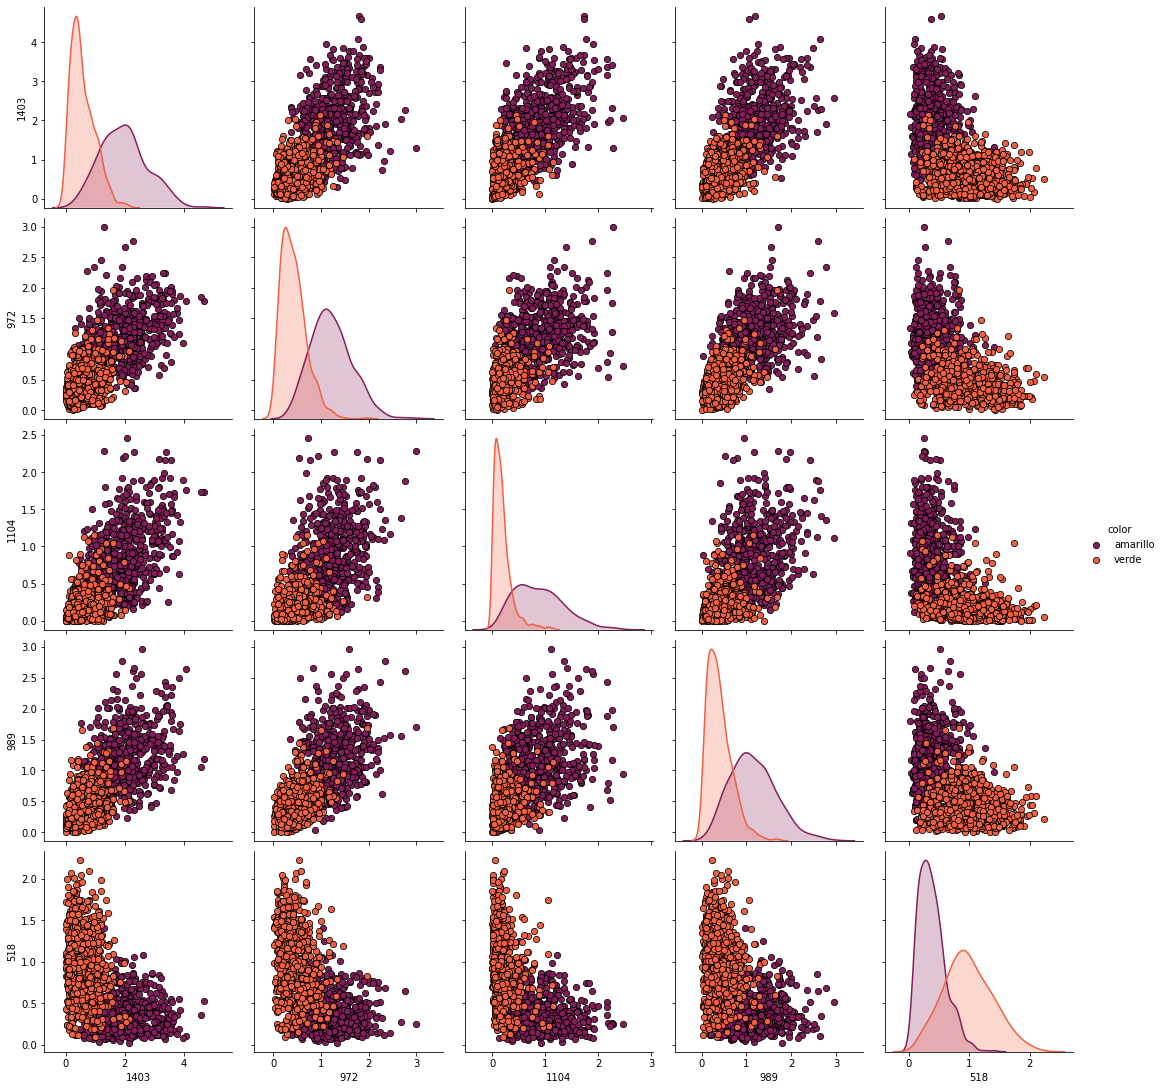

In [ ]:
#realizamos un pairplot para ver gráficamente las tendencias lineales
sns.pairplot(data=df_gsi, vars=colcorr_features, hue='color', height=3, palette='rocket', plot_kws=
    {
    "s":40,
    "alpha":1.0,
    'lw':0.5,
    'edgecolor':'k'
    })
fig.legend(loc='upper center', ncol=1)

A partir del pairplot podemos ver que las variables toman distintas distribuciones dependiendo del color del guante, y que algunas de estas variables estan directamente relacionadas entre si.

Vamos a tratar de determinar mediante KS test que distribuciones tienen mejor fit en las variables que estamos analizando, para guante amarillo y guante verde.

In [ ]:
getKS(dfgsi_enc[dfgsi_enc['color_enc']==0], colcorr_features)

lista de features: ['1403' '972' '1104' '989' '518']



Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
2  weibull_max  0.02784  0.75297    1403
5        gamma  0.02817  0.74014    1403
4     invgauss  0.02892  0.71017    1403
7      lognorm  0.02924  0.69735    1403
3         beta  0.03485  0.46976    1403
0  weibull_min  0.03554  0.44341    1403
1         norm  0.04274  0.22763    1403
6        expon  0.26392  0.00000    1403
8       triang  0.11196  0.00000    1403

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
5        gamma  0.01965  0.97726     972
2  weibull_max  0.01972  0.97642     972
4     invgauss  0.01992  0.97398     972
7      lognorm  0.02049  0.96624     972
3         beta  0.02185  0.94198     972
0  weibull_min  0.02327  0.90836     972
1         norm  0.04345  0.21165     972
6        expon  0.25331  0.00000     972
8       triang  0.16580  0.00000     972

Distributions

,Feature,Distribution,D_value,p_value
0,1403,weibull_max,0.02784,0.75297
1,972,gamma,0.01965,0.97726
2,1104,beta,0.02408,0.88543
3,989,weibull_min,0.01720,0.99505
4,518,beta,0.01811,0.99061


In [ ]:
getKS(dfgsi_enc[dfgsi_enc['color_enc']==1], colcorr_features)

lista de features: ['1403' '972' '1104' '989' '518']



Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
0  weibull_min  0.03365  0.41187    1403
5        gamma  0.03374  0.40828    1403
3         beta  0.03504  0.36067    1403
4     invgauss  0.04229  0.16596    1403
7      lognorm  0.04353  0.14321    1403
2  weibull_max  0.04975  0.06416    1403
1         norm  0.11265  0.00000    1403
6        expon  0.13296  0.00000    1403
8       triang  0.14871  0.00000    1403

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  D_value  p_value Feature
0  weibull_min  0.02477  0.79265     972
3         beta  0.02944  0.59501     972
5        gamma  0.02945  0.59481     972
4     invgauss  0.03525  0.35361     972
7      lognorm  0.03559  0.34169     972
2  weibull_max  0.03832  0.25847     972
1         norm  0.08024  0.00027     972
6        expon  0.17826  0.00000     972
8       triang  0.29796  0.00000     972

Distributions

,Feature,Distribution,D_value,p_value
0,1403,weibull_min,0.03365,0.41187
1,972,weibull_min,0.02477,0.79265
2,1104,weibull_min,0.04027,0.20916
3,989,weibull_min,0.02001,0.94576
4,518,gamma,0.01825,0.97600


Al realizar el test de KS para variables con guante amarillo y guante verde, podemos concluir que estas variables cambian su distribucion dependiendo del color, y por ello estas estan fuertemente relacionadas con la variable de color.

In [ ]:
cols = df_gsi.columns[10:]
print(cols)

# Tomamos la mediana de cada grupo para realizar un grafico comparativo entre los dos

amarillo = df_gsi[df_gsi['color']=='amarillo'][cols].median()
verde = df_gsi[df_gsi['color']=='verde'][cols].median()

# Nos vamos a quedar solo con las columnas de filename, color y los feature vectors de dataset original

list2 = list(zip(amarillo, verde))
df2 = pd.DataFrame(list1, columns=['amarillo', 'verde'])
df2.index.name = 'feature'
df2.head()

# En este caso tomamos la mediana ya que al tener valores muy dispersos en los features, 
# y con distribuciones no normales, la media podria no ser representativa

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046',
       '2047'],
      dtype='object', length=2048)


,amarillo,verde
feature,,
0,0.495536,0.264785
1,0.277144,0.246876
2,0.395551,0.322757
3,0.304784,0.303937
4,0.170227,0.164471


In [ ]:
df2.plot_bokeh.line(
    y=['amarillo', 'verde'],
    figsize=(800, 450),
    title="Features",
    vertical_xlabel=True,
    xticks=[int(x) for x in colcorr_features],
    ylim=(0, 4),
    toolbar_location=None,
    colormap=["yellow", "green"],
)

Figure(id='1533', ...)

Cada "pico" en el siguiente grafico, representa la media del valor de activacion para cada feature de las imagenes; esto quiere decir que cada feature del vector representa un filtro y su nivel de activacion de la imagen al pasar por la red neuronal.

Podemos tambien decir que el resto de los filtros en que se diferencian los grupos son los que determinan si las imagenes tienen distintos colores o formas de mano y guante.